In [60]:
import numpy as np
import pandas as pd
import re

In [61]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [62]:
df = pd.read_csv('gurgaon_properties_cleaned_v.csv')

In [63]:
df = df[df["areaWithType"].notnull()]

In [64]:
df.duplicated().sum()

122

###  focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

In [65]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,central park flower valley,sector 33,1.55,11923.0,1300.0,Carpet area: 1300 (120.77 sq.m.),3,3.0,3+,not available,7.0,North-East,0 to 1 Year Old,"['Golf Course Extension Rd', 'Rajiv Chowk - Sohna Highway', 'KMP corridor', 'Marigold Secondary School', 'Alpine Convent School', 'The Millenium School', 'GD Goenka University', 'Medanta Hospital', 'Alpine Hospital', 'Pushpanjali Hospital', 'IGI Airport', 'Country Inn', 'Westin', 'Central Park Resorts', 'De Adventure Park']","['4 Wardrobe', '7 Fan', '3 Geyser', '11 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', '2 Curtains', 'No Bed', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"


## 1. areaWithType

 there are three types of area  
 ##### super built up area ->ex-stairs ,garden/common property 
 ##### built up area ->carpet area+thickness of walls + area of balcony  
 ##### carpet area -> area
##### plot area ->for houses  builtup area
we are going to make three columns "super_built_up_area" , "built_up_area", "carpet_area"

In [66]:
df.sample(5)[['area','areaWithType']]

,area,areaWithType
1701,1350.0,Plot area 163(136.29 sq.m.)Built Up area: 161 sq.yards (134.62 sq.m.)Carpet area: 150 sq.yards (125.42 sq.m.)
89,1276.0,Carpet area: 1276 (118.54 sq.m.)
2633,1235.0,Carpet area: 1235 (114.74 sq.m.)
986,1727.0,Super Built up area 1727(160.44 sq.m.)Carpet area: 1017 sq.ft. (94.48 sq.m.)
1463,500.0,Built Up area: 500 (46.45 sq.m.)Carpet area: 300 sq.ft. (27.87 sq.m.)


In [67]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None
    

In [68]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [69]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [70]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [71]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2102,1.80,flat,1921.0,Super Built up area 1921(178.47 sq.m.)Carpet area: 1227.96 sq.ft. (114.08 sq.m.),1921.0,NaN,1227.96
1859,12.39,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN
1788,1.35,flat,2350.0,Super Built up area 2350(218.32 sq.m.),2350.0,NaN,NaN
1773,0.91,flat,1447.0,Carpet area: 1439 (133.69 sq.m.),NaN,NaN,1439.00
122,0.80,flat,988.0,Carpet area: 990 (91.97 sq.m.),NaN,NaN,990.00


In [72]:
df.duplicated().sum()

122

In [74]:
#those flats/house whose size of three types  area are given
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [80]:
# those house whoose plot area is given
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
17,11.95,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
19,12.00,house,3078.0,Plot area 342(285.96 sq.m.),NaN,NaN,NaN
21,1.60,house,508.0,Plot area 60(50.17 sq.m.),NaN,NaN,NaN
27,7.10,house,2160.0,Plot area 240(200.67 sq.m.)Built Up area: 239 sq.yards (199.83 sq.m.)Carpet area: 238 sq.yards (199 sq.m.),NaN,239.0,238.0
29,3.50,house,1722.0,Plot area 160,NaN,NaN,NaN


In [81]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [82]:
#those rows such that all three rows values are null
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [84]:
all_nan_df.shape

(546, 7)

In [89]:
all_nan_df.sample(5)
#here we can see all of them have plot area -> they are house

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
52,6.95,house,1800.0,Plot area 192(160.54 sq.m.),NaN,NaN,NaN
3273,0.35,house,360.0,Plot area 40(33.45 sq.m.),NaN,NaN,NaN
2445,4.60,house,3771.0,Plot area 419(350.34 sq.m.),NaN,NaN,NaN
2232,3.15,house,1548.0,Plot area 172(143.81 sq.m.),NaN,NaN,NaN
375,11.00,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN


In [91]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [92]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [93]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [94]:
all_nan_df
#but there is a problem -> in units (three types of unit sqrtyrd and sqft and sqm) -> convert them all to sq.m

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
17,11.95,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
19,12.00,house,3078.0,Plot area 342(285.96 sq.m.),NaN,342.00,NaN
21,1.60,house,508.0,Plot area 60(50.17 sq.m.),NaN,60.00,NaN
29,3.50,house,1722.0,Plot area 160,NaN,160.00,NaN
30,5.60,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
52,6.95,house,1800.0,Plot area 192(160.54 sq.m.),NaN,192.00,NaN
54,2.00,house,1337.0,Plot area 1337.4(124.25 sq.m.),NaN,1337.40,NaN
61,7.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
62,4.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,358.00,NaN
65,1.70,house,1800.0,Plot area 1800(167.23 sq.m.),NaN,1800.00,NaN


In [95]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [96]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [97]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
17,11.95,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
19,12.00,house,3078.0,Plot area 342(285.96 sq.m.),NaN,3078.00,NaN
21,1.60,house,508.0,Plot area 60(50.17 sq.m.),NaN,60.00,NaN
29,3.50,house,1722.0,Plot area 160,NaN,1712.00,NaN
30,5.60,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
52,6.95,house,1800.0,Plot area 192(160.54 sq.m.),NaN,1728.00,NaN
54,2.00,house,1337.0,Plot area 1337.4(124.25 sq.m.),NaN,1337.40,NaN
61,7.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
62,4.35,house,3222.0,Plot area 358(299.33 sq.m.),NaN,3222.00,NaN
65,1.70,house,1800.0,Plot area 1800(167.23 sq.m.),NaN,1800.00,NaN


In [98]:
# update the original dataframe
df.update(all_nan_df)

In [99]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [595]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,"study room,servant room",4.0,NaN,Within 6 months,"['Sant Soordas Sihi Metro Station', 'Airia Mall', 'Dwarka Expressway', 'Pataudi Road', 'NH-8', 'KMP Expressway', 'RPS International School', 'Genesis Hospital Sector 84', 'Gurgaon Railway Station', 'Vatika Business Park Sector 49', 'Holiday Inn Gurugram Sector 90', 'De Adventure Amusement Park', 'National Tennis Academy Sector 98', 'IMT Manesar']",NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Piped-gas', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center']",NaN,NaN,1103.0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,not available,0.0,NaN,Under Construction,"['V3S Sapphire Ninety Mall', 'Sector 86 Road', 'Dwarka Expy', 'RPS International School', 'SGT University', 'Shree Radhey Hospital And Trauma Center', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']",[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 585 sq.ft. (54.35 sq.m.),2,2,1,not available,17.0,NaN,0 to 1 Year Old,"['Huda City Centre', 'Omaxe City Centre', 'Ninex City Mart', 'Vaels Ravindra Bharathi Global School', 'Anjali nursery', 'Polaris Hospital', 'Axis Bank', 'Triangular Park', 'Flow Sports Life Badminton Club', 'Basai Dhankot Railway Station', 'Cars24', 'Radisson Hotel Gurugram', ""McDonald's"", 'Petrol Pump', 'Indian Post Office']",[],"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,1000.0,585.0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up area: 1615 sq.ft. (150.04 sq.m.)Carpet area: 1476 sq.ft. (137.12 sq.m.),3,4,3+,"servant room,others",10.0,North-West,1 to 5 Year Old,"['Sapphire 93 Mall', 'Dwarka Expressway', 'NH-8, Imt Manesar', 'Western Peripheral Expressway', 'RPS International School Sector 89', 'DPG Institute of Technology', 'Aarvy Healthcare Hospital', 'Indira Gandhi International Airport', 'Holiday Inn Sector 90', 'De Adventure Park', 'National Tennis Academy Sector 98']","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Geyser', '15 Light', '5 AC', '1 Chimney', '4 Curtains', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM'

## 2.additionalRoom

In [100]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

In [101]:
# additional room ->there are five types of room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [102]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
1311,servant room,0,1,0,0,0
488,others,0,0,0,0,1
1012,not available,0,0,0,0,0
2266,not available,0,0,0,0,0
2469,study room,1,0,0,0,0


In [599]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,0 to 1 Year Old,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,"study room,servant room",4.0,NaN,Within 6 months,"['Sant Soordas Sihi Metro Station', 'Airia Mall', 'Dwarka Expressway', 'Pataudi Road', 'NH-8', 'KMP Expressway', 'RPS International School', 'Genesis Hospital Sector 84', 'Gurgaon Railway Station', 'Vatika Business Park Sector 49', 'Holiday Inn Gurugram Sector 90', 'De Adventure Amusement Park', 'National Tennis Academy Sector 98', 'IMT Manesar']",NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Piped-gas', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center']",NaN,NaN,1103.0,1,1,0,0,0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,not available,0.0,NaN,Under Construction,"['V3S Sapphire Ninety Mall', 'Sector 86 Road', 'Dwarka Expy', 'RPS International School', 'SGT University', 'Shree Radhey Hospital And Trauma Center', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']",[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0,0,0,0,0,0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 585 sq.ft. (54.35 sq.m.),2,2,1,not available,17.0,NaN,0 to 1 Year Old,"['Huda City Centre', 'Omaxe City Centre', 'Ninex City Mart', 'Vaels Ravindra Bharathi Global School', 'Anjali nursery', 'Polaris Hospital', 'Axis Bank', 'Triangular Park', 'Flow Sports Life Badminton Club', 'Basai Dhankot Railway Station', 'Cars24', 'Radisson Hotel Gurugram', ""McDonald's"", 'Petrol Pump', 'Indian Post Office']",[],"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,1000.0,585.0,0,0,0,0,0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up area: 1615 sq.ft. (150.04 sq.m.)Carpet area: 1476 sq.ft. (137.12 sq.m.),3,4,3+,"servant room,others",10.0,North-West,1 to 5 Year Old,"['Sapphire 93 Mall', 'Dwarka Expressway', 'NH-8, Imt Manesar', 'Western Peripheral Expressway', 'RPS International School Sector 89', 'DPG Institute of Technology', 'Aarvy Healthcare Hospital', 'Indira Gandhi International Airport', 'Holiday Inn Sector 90', 'De Adventure Park', 'National Tennis Academy Sector 98']","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Geyser', '15 Light', '5 AC', '1 Chimney', '4 Curtains', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal'

## 3.agePossession

In [103]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Jun 2024                 7
Dec 2025                 7
Nov 2023                 5
Oct 2023                 4
Sep 2023                 4
By 2025                  4
Jul 2024                 4
Aug 2024                 4
May 2024                 3
Jan 2025                 3
Nov 2024                 3
Feb 2024                 3
Dec 2026                 2
Sep 2025                 2
Jan 2026                 2
Mar 2025                 2
Jul 2025                 2
Jun 2027                 2
By 2027                  2
Jul 2027                 2
Aug 2025      

In [104]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [105]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [106]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [604]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global park 4,sector 36,0.82,7585.0,1081.0,Super Built up area 1081(100.43 sq.m.)Carpet area: 650 sq.ft. (60.39 sq.m.),3,2,2,not available,2.0,NaN,New Property,"['Sector 55-56 Metro Station', 'The Leaf Mall Sohna', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy', 'Vidya Niketan School', 'KIIT College of Engg', 'Scottish High International School', 'Rawal Institutions', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Spaze Business Park', 'DLF Cyber City']",NaN,"['Lift(s)', 'Park']",1081.0,NaN,650.0,0,0,0,0,0
1,flat,smart world gems,sector 89,0.95,8600.0,1105.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,"study room,servant room",4.0,NaN,New Property,"['Sant Soordas Sihi Metro Station', 'Airia Mall', 'Dwarka Expressway', 'Pataudi Road', 'NH-8', 'KMP Expressway', 'RPS International School', 'Genesis Hospital Sector 84', 'Gurgaon Railway Station', 'Vatika Business Park Sector 49', 'Holiday Inn Gurugram Sector 90', 'De Adventure Amusement Park', 'National Tennis Academy Sector 98', 'IMT Manesar']",NaN,"['Power Back-up', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Piped-gas', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center']",NaN,NaN,1103.0,1,1,0,0,0
2,flat,pyramid elite,sector 86,0.46,79.0,58228.0,Carpet area: 58141 (5401.48 sq.m.),2,2,1,not available,0.0,NaN,Under Construction,"['V3S Sapphire Ninety Mall', 'Sector 86 Road', 'Dwarka Expy', 'RPS International School', 'SGT University', 'Shree Radhey Hospital And Trauma Center', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']",[],"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,58141.0,0,0,0,0,0
3,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 585 sq.ft. (54.35 sq.m.),2,2,1,not available,17.0,NaN,New Property,"['Huda City Centre', 'Omaxe City Centre', 'Ninex City Mart', 'Vaels Ravindra Bharathi Global School', 'Anjali nursery', 'Polaris Hospital', 'Axis Bank', 'Triangular Park', 'Flow Sports Life Badminton Club', 'Basai Dhankot Railway Station', 'Cars24', 'Radisson Hotel Gurugram', ""McDonald's"", 'Petrol Pump', 'Indian Post Office']",[],"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,1000.0,585.0,0,0,0,0,0
4,flat,bestech park view sanskruti,sector 92,1.60,8020.0,1995.0,Super Built up area 1995(185.34 sq.m.)Built Up area: 1615 sq.ft. (150.04 sq.m.)Carpet area: 1476 sq.ft. (137.12 sq.m.),3,4,3+,"servant room,others",10.0,North-West,Relatively New,"['Sapphire 93 Mall', 'Dwarka Expressway', 'NH-8, Imt Manesar', 'Western Peripheral Expressway', 'RPS International School Sector 89', 'DPG Institute of Technology', 'Aarvy Healthcare Hospital', 'Indira Gandhi International Airport', 'Holiday Inn Sector 90', 'De Adventure Park', 'National Tennis Academy Sector 98']","['3 Wardrobe', '6 Fan', '1 Exhaust Fan', '3 Geyser', '15 Light', '5 AC', '1 Chimney', '4 Curtains', '1 Modular Kitchen', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Wa

## 4.furnishDetails

##### there are 18 items in furnish detailsthere are 18 items in furnish details.We are going to divide them in 3 catagory furnished,semifurnished, unfurnished -using clustering

In [110]:
df.sample(5)[['furnishDetails','features']]
#there are 18 items in furnish details

,furnishDetails,features
2427,[],"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Maintenance Staff', 'Water Storage', 'Park', 'Security Personnel', 'Club house / Community Center', 'Rain Water Harvesting']"
2775,[],NaN
1499,NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
452,"['1 Water Purifier', '4 Fan', '1 Fridge', '1 Dining Table', '2 Geyser', '10 Light', '4 AC', '1 TV', '1 Chimney', '3 Bed', '3 Wardrobe', '1 Microwave', 'No Curtains', 'No Exhaust Fan', 'No Modular Kitchen', 'No Sofa', 'No Stove', 'No Washing Machine']","['Water purifier', 'Centrally Air Conditioned', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
1904,"['1 Exhaust Fan', '1 Stove', '5 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Centrally Air Conditioned', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']"


In [111]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [112]:
furnishings_df.shape

(3803, 19)

In [113]:
furnishings_df = furnishings_df.drop(columns=['furnishDetails'])

In [115]:
furnishings_df.sample(5)

,Exhaust Fan,Fridge,Curtains,Wardrobe,Microwave,Light,Water Purifier,Washing Machine,Modular Kitchen,Sofa,Chimney,Fan,Bed,Dining Table,Geyser,AC,TV,Stove
1825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1787,1,0,0,4,0,13,0,0,1,0,1,4,0,0,4,1,0,0
3096,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2345,1,0,0,2,0,10,0,0,1,0,0,3,0,0,3,0,0,0


In [116]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [117]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [118]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

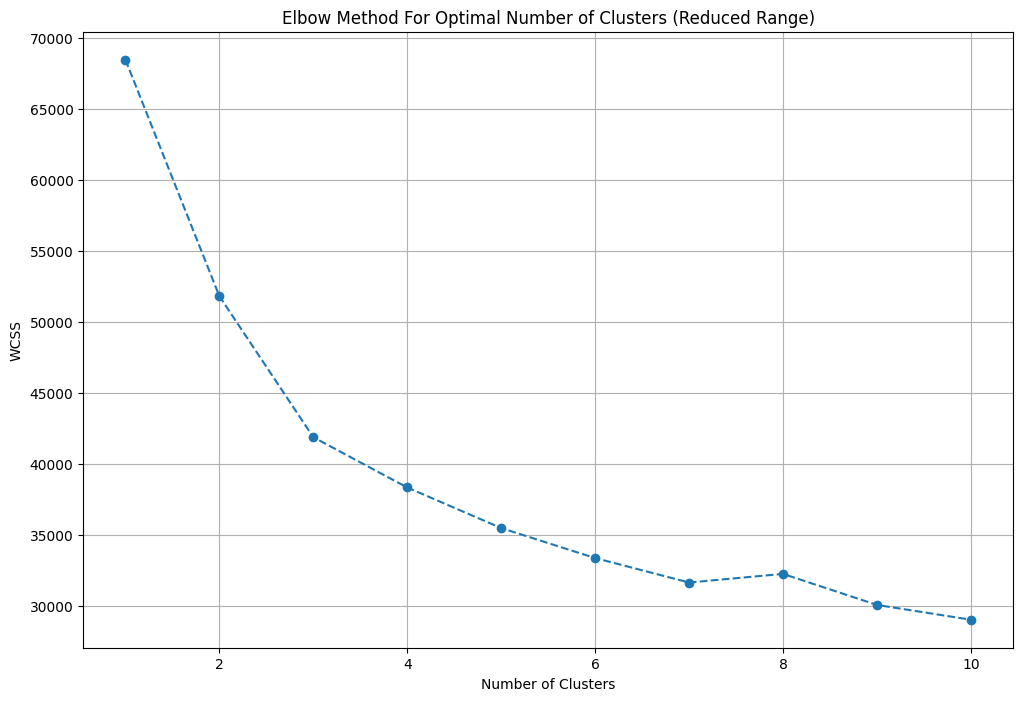

In [119]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [120]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [121]:
df = df.iloc[:,:-18]

In [122]:
df['furnishing_type'] = cluster_assignments

In [125]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
396,"['7 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
1841,"['3 Fan', '3 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
2751,"['1 Water Purifier', '3 Fan', '1 Fridge', '1 Exhaust Fan', '1 Geyser', '1 Stove', '25 Light', '1 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '2 Bed', '2 Wardrobe', '1 Sofa', '1 Microwave', 'No Dining Table', 'No Washing Machine']",2
3387,"['3 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
852,"['2 Wardrobe', '1 Exhaust Fan', '14 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1


## 5.features

In [126]:
df[['society','features']].sample(5)

,society,features
600,indiabulls enigma,"['Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3620,dlf the belaire,"['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']"
1144,suposhaa smartworld orchard,NaN
2716,sbtl caladium,"['Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3657,m3m skywalk,"['Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Piped-gas', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [512]:
df['features'].isnull().sum()
#we fill them using apertnents table ->facility

635

In [129]:
import pandas as pd
app_df = pd.read_csv('appartments.csv')
app_df.sample(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
62,Smart World Gems,"2, 3 BHK Independent Floor in Sector 89, Gurgaon","['Genesis Hospital Sector 84', 'Dwarka Expressway', 'RPS International School', 'Holiday Inn Gurugram Sector 90', 'Sant Soordas Sihi Metro Station']","{'Genesis Hospital Sector 84': '2.2 Km', 'Dwarka Expressway': '2.9 Km', 'RPS International School': '3.4 Km', 'Holiday Inn Gurugram Sector 90': '4.1 Km', 'Sant Soordas Sihi Metro Station': '5.1 Km', 'Pataudi Road': '8.5 Km', 'National Tennis Academy Sector 98': '8.7 Km', 'IMT Manesar': '9.5 Km', 'NH-8': '9.5 Km', 'Gurgaon Railway Station': '12.4 Km', 'De Adventure Amusement Park': '15 Km', 'KMP Expressway': '15.4 Km', 'Vatika Business Park Sector 49': '17 Km', 'Airia Mall': '17 Km'}",https://www.99acres.com/smart-world-gems-sector-89-gurgaon-npxid-r378133,"{'2 BHK': {'building_type': 'Independent Floor', 'area_type': 'Carpet Area', 'area': '1,067 - 1,105 sq.ft.', 'price-range': '₹ 83 - 90.17 L'}, '3 BHK': {'building_type': 'Independent Floor', 'area_type': 'Carpet Area', 'area': '1,423 sq.ft.', 'price-range': '₹ 1.16 - 1.25 Cr'}}","['Swimming Pool', 'Lounge', 'Aerobics Centre', 'Terrace Garden', 'Piped Gas', 'Squash Court', 'Gazebo', 'Wi-Fi Connectivity', 'Sun Deck']"
187,Paras Dews,"2, 3, 4 BHK Apartment in Sector 106, Gurgaon","['NeoSquare Shopping Mall', 'Glorious World School', 'Chirag Hospital', 'Hamoni Golf Camp', 'Country Inn & Suites by Radisson']","{'NeoSquare Shopping Mall': '1.3 Km', 'Glorious World School': '1.9 Km', 'Chirag Hospital': '2.4 Km', 'Hamoni Golf Camp': '8.5 Km', 'Country Inn & Suites by Radisson': '7.9 Km', 'SkyJumper Trampoline Park': '10.6 Km', 'DPG Institute of Technology': '11.8 Km', 'MG Road Metro Station': '11.4 Km', 'Indira Gandhi International Airport': '19.4 Km', 'Gurgaon': '2.9 Km', 'Dwarka Expressway': '1.7 Km'}",https://www.99acres.com/paras-dews-sector-106-gurgaon-npxid-r28300,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,385 sq.ft.', 'price-range': '₹ 1.09 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,665 - 1,900 sq.ft.', 'price-range': '₹ 1.32 - 1.51 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,355 - 4,150 sq.ft.', 'price-range': '₹ 1.87 - 3.31 Cr'}}","['Swimming Pool', 'Lounge', 'Reflexology Park', 'School', 'Aerobics Centre', 'Card Room', 'Sauna', 'Jacuzzi', 'Spa']"


In [130]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [131]:
temp_df = df[df['features'].isnull()]

In [132]:
temp_df.shape

(635, 26)

In [137]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [138]:
df.loc[temp_df.index,'features'] = x.values

In [139]:
df['features'].isnull().sum()

481

In [140]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast


In [141]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [142]:
features_binary_df.sample(5)
#130 columns ->luxary,semi-luxary, budget

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
3241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3660,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
features_binary_df.shape

(3803, 130)

In [144]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

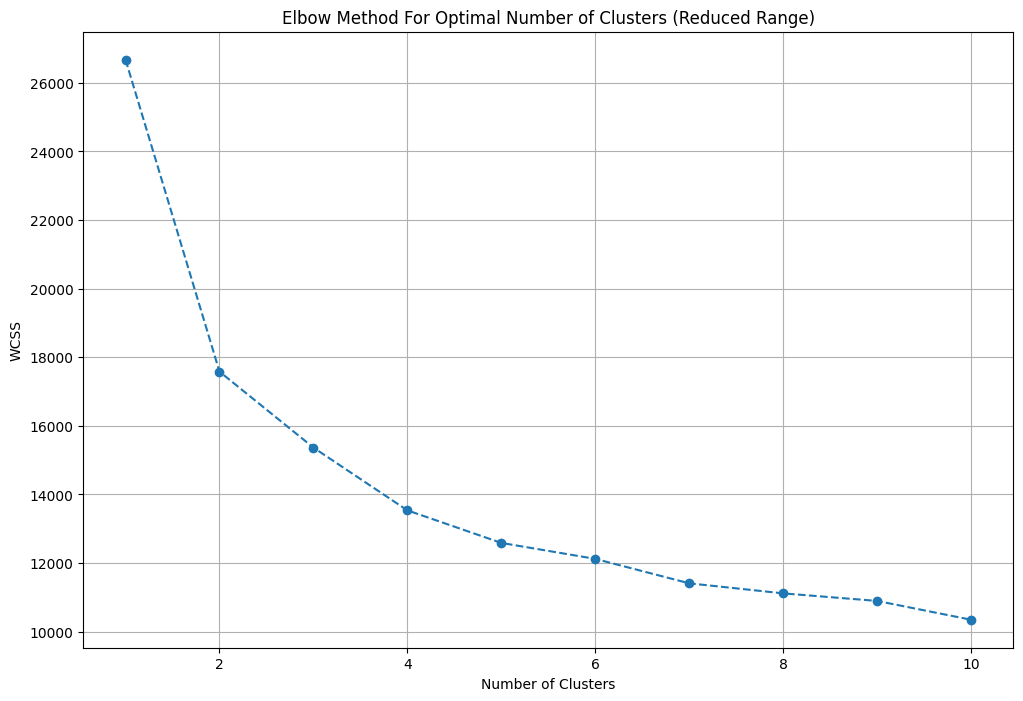

In [145]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [147]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [148]:
df['luxury_score'] = luxury_score

In [151]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
3763,flat,tulsiani easy in homes,sohna road,0.40,7920.0,505.0,Carpet area: 505 (46.92 sq.m.),2,2.0,3,not available,9.0,NaN,Under Construction,"['Huda City Metro', 'Golf Course extn road', 'Rajiv Chowk', 'IGI Airport', 'IMT Sohna', 'Damdama Lake']",NaN,"['Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Park', 'Fitness Centre / GYM', 'Club house / Community Center']",NaN,NaN,505.0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), Swimming Pool, Park, Fitness Centre / GYM, Club house / Community Center]",36
2797,flat,hero homes,sector 104,1.90,11249.0,1689.0,Super Built up area 1689(156.91 sq.m.)Carpet area: 1082 sq.ft. (100.52 sq.m.),3,3.0,3,pooja room,16.0,NaN,Under Construction,"['Basai Metro Station', 'HUDA Market', 'Dwarka Expressway', 'Kings International School', 'Aryan Hospital', 'IGI Airport', 'Gurugram Railway Station']","['1 Water Purifier', '1 Exhaust Fan', '3 Geyser', '5 AC', '1 Chimney', '1 Modular Kitchen', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fan', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Water purifier', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']",1689.0,NaN,1082.0,0,0,0,1,0,1,"[Security / Fire Alarm, Feng Shui / Vaastu Compliant, Intercom Facility, Lift(s), Water purifier, Maintenance Staff, Water Storage, No open drainage around, Piped-gas, Swimming Pool, Park, Security Personnel, Natural Light, Internet/wi-fi connectivity, Shopping Centre, Fitness Centre / GYM, Waste Disposal, Rain Water Harvesting, Club house / Community Center]",103
1036,flat,corona gracieux,sector 76,1.08,5510.0,1960.0,Super Built up area 1960(182.09 sq.m.),3,3.0,3,servant room,1.0,NaN,New Property,"['Entertainland Mall', 'Delhi Ajmer Expressway', 'Kunskapsskolan School', 'Suzuki Motorcycle India Office']",NaN,"['Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Piped-gas', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']",1960.0,NaN,NaN,0,1,0,0,0,0,"[Feng Shui / Vaastu Compliant, Lift(s), Maintenance Staff, Swimming Pool, Park, Piped-gas, Security Personnel, Shopping Centre, Fitness Centre / GYM, Club house / Community Center, Rain Water Harvesting]",58
2334,flat,shree vardhman victoria,sector 70,1.66,14254.0,1165.0,Super Built up area 1950(181.16 sq.m.)Carpet area: 1161 sq.ft. (107.86 sq.m.),3,5.0,3,servant room,8.0,North,Relatively New,"['Airia Mall', 'Golf Course Extn Road', 'Sohna Road', 'Southern Peripheral Rd, Gurugram', 'Kunskapsskolan International', 'Ektaa Hospitals Main Sohna Rd', 'Sanjeevani Hospital - Child Specialist', 'Federal Bank Sector 71', 'Central Bank Of India Sohna Rd', 'Axis Bank, Sohna Rd', 'Spaze Palazo, Golf Course Ext Rd', 'VATIKA BUSINESS PARK Sohna Rd', 'The Medicity, Spaze iTech Park', 'Tulip Violet Society, Sector 69', 'IndianOil, Hasanpur']","['3 Wardrobe', '1 Washing Machine', '3 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maint

In [152]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [153]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2237,flat,bptp terra,sector 37d,1.40,7730.0,1811.0,Super Built up area 1811(168.25 sq.m.)Built Up area: 1711 sq.ft. (158.96 sq.m.)Carpet area: 1611 sq.ft. (149.67 sq.m.),3,3.0,3,5.0,South-East,Relatively New,1811.0,1711.0,1611.0,0,0,0,0,0,1,149
3604,flat,mittal cosmos executive apartments,sector 2,0.75,6550.0,1145.0,Super Built up area 1145(106.37 sq.m.)Built Up area: 1100 sq.ft. (102.19 sq.m.),2,2.0,2,15.0,NaN,Old Property,1145.0,1100.0,NaN,0,0,0,0,0,1,42
1340,flat,dlf belvedere towers,sector 25,3.70,17619.0,2100.0,Carpet area: 2100 (195.1 sq.m.),4,4.0,3,18.0,North-West,Old Property,NaN,NaN,2100.0,0,1,0,0,0,1,26
197,flat,mapsko casa bella,sector 82,3.00,6134.0,4891.0,Super Built up area 4890(454.3 sq.m.),4,6.0,3+,25.0,West,Relatively New,4890.0,NaN,NaN,0,1,0,1,0,1,119
696,flat,godrej habitat,sector 3,1.30,9002.0,1444.0,Carpet area: 1444 (134.15 sq.m.),2,2.0,2,6.0,NaN,Under Construction,NaN,NaN,1444.0,0,0,0,0,0,0,36


In [154]:
df.shape

(3803, 23)

In [155]:
df.to_csv('gurgaon_properties_cleaned_v2.csv',index=False)